# **Business Objective: Predicting COVID-19 Deaths based on Health and Socioeconomic Factors**

#### Coronavirus disease 2019 (COVID-19) is a devastating infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). COVID-19 can lead to pneumonia, long-lasting damage to lungs, and blood clotting and sepsis to almost every body organ resulting in death. First discovered and identified in December 2019, it has led to over 150,000 deaths in the US and over 670,000 deaths worldwide as of July 2020, with the numbers increasing daily. Here, we predict the number of COVID-19 deaths using state-by-state data on health and socioeconomic factors that may contribute to the death numbers. [This data](https://www.kaggle.com/nightranger77/covid19-state-data) was posted in May 2020 and reflects the first surge of COVID-19 cases only. A second, more prolonged and exponentially bigger surge occurred in mid-June as states and businesses prematurely reopened at the start of summer. Large social gatherings, civil unrest and protests, mixed messaging on mitigating the spread, and asymptomatic spread / delayed test results with the inability to contact trace further exacerbated the surge. The most affected age group in this second surge shifted down from 50+ to 20-44 years old, and the hardest hit states and regions shifted from the NY - NJ - CT tri-state area to FL, TX, AZ, CA, and The Deep South. Additional states have surged in COVID-19 cases since then, resulting in a rise in positivity rates throughout the U.S.

#### Analysis for the COVID-19 dataset was done using **Multiple Linear Regression, Random Forest Regression, and XGBoost Regression**. Models were compared for accuracy.

## Import the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import the dataset

In [ ]:
covid = pd.read_csv('COVID19_state.csv')

## ***Data preprocessing***

## Check for Null Values

In [ ]:
null_count = covid.isnull().sum()
null_pct = ((covid.isnull().sum())/(covid.isnull().count()))*100
null_type = covid.dtypes
missing_data = pd.concat([null_count, null_pct, null_type], axis = 1, keys = ['Null Values', 'Percent of Total', 'Data Type'])
missing_data = missing_data.sort_values(by = 'Percent of Total', ascending = False).round(2)
missing_data

,Null Values,Percent of Total,Data Type
School Closure Date,3,5.88,object
Tested,0,0.00,int64
Age 55+,0,0.00,float64
Age 26-54,0,0.00,float64
Age 0-25,0,0.00,float64
Urban,0,0.00,float64
Temperature,0,0.00,float64
Med-Large Airports,0,0.00,float64
Pollution,0,0.00,float64
Health Spending,0,0.00,int64


In [ ]:
# Fill NA in School Closure Date with most commonly occurring date
covid = covid.fillna(covid['School Closure Date'].value_counts().index[0])

In [ ]:
covid.head(10)

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,Unemployment,Sex Ratio,Smoking Rate,Flu Deaths,Respiratory Deaths,Physicians,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,Alaska,36380,399,10,734002,1.2863,0.4081,119,59687,73205,5.8,1.054688,21.0,12.1,35.3,1900,21,11064,6.4,1.0,26.60,66.0,0.36,0.39,0.25,03/19/20
1,Alabama,157566,12376,504,4908621,96.9221,0.4847,1533,42334,45219,2.7,0.930145,20.9,21.4,58.0,12205,101,7281,8.1,1.0,62.80,59.0,0.33,0.37,0.31,03/16/20
2,Arkansas,93701,4923,102,3038999,58.4030,0.4719,732,42566,42454,3.5,0.956630,22.3,18.0,61.7,7150,88,7408,7.1,0.0,60.40,56.2,0.34,0.37,0.30,03/17/20
3,Arizona,220612,14566,704,7378494,64.9550,0.4713,1559,43650,48055,4.5,0.966965,15.6,12.4,41.2,17806,83,6452,9.7,1.0,60.30,89.8,0.33,0.36,0.30,03/16/20
4,California,1339316,81795,3334,39937489,256.3727,0.4899,7338,62586,74205,3.9,0.975113,11.3,15.6,30.9,112906,359,7549,12.8,9.0,59.40,95.0,0.33,0.40,0.26,03/19/20
5,Colorado,131837,22482,1257,5845526,56.4011,0.4586,1597,56846,63882,2.5,0.994850,14.6,9.7,44.0,14509,89,6804,6.7,1.0,45.10,86.2,0.33,0.40,0.27,03/23/20
6,Connecticut,185520,38430,3472,3563077,735.8689,0.4945,674,74561,76342,3.8,0.947106,12.7,14.8,28.9,15605,32,9859,7.2,1.0,49.00,88.0,0.30,0.38,0.32,03/17/20
7,District of Columbia,39374,7434,400,720687,11814.5410,0.5420,314,47285,200277,5.2,0.888570,14.3,11.2,19.6,7346,10,11944,9.8,0.0,54.65,100.0,0.30,0.48,0.22,03/16/20
8,Delaware,44132,8037,304,982895,504.3073,0.4522,186,51449,77253,3.9,0.926194,17.0,13.1,40.4,3148,7,10254,8.3,0.0,55.30,83.3,0.30,0.37,0.33,03/16/20
9,Florida,681314,45684,2052,21992985,410.1256,0.4852,5604,49417,48318,2.8,0.942213,16.1,9.6,37.0,56499,217,8076,7.4,7.0,70.70,91.2,0.29,0.37,0.35,03/16/20


## ***Exploratory Data Analysis***

## Determine Feature Correlations

In [ ]:
def make_corr_map(df, title, size=(9,7)):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr)) # for upper triangle
    f, ax = plt.subplots(figsize=size)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)


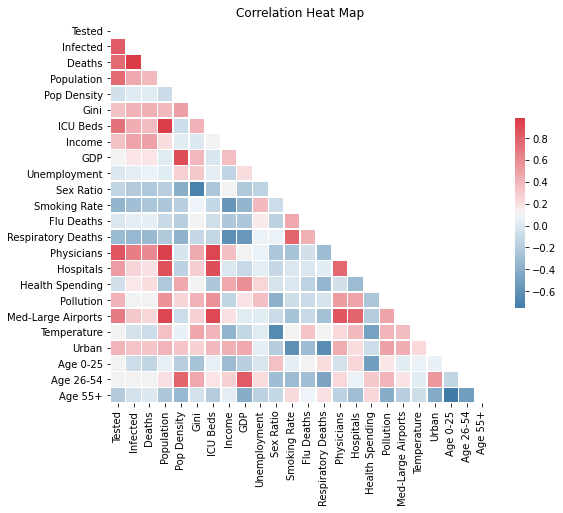

In [ ]:
make_corr_map(covid, 'Correlation Heat Map')

Too many features are correlated, making it difficult to select which ones to remove and which ones to keep. Let's simplify by separating the features into two general groups.

## Group Features by Health and Socioeconomic Factors

In [ ]:
# Drop New Jersey data since their number of deaths is an outlier
covid = covid.drop(covid.index[31])

socio = ['State', 'School Closure Date', 'Population', 'Pop Density', 'Gini', 'Income', 'GDP', 'Unemployment',
         'Sex Ratio', 'Health Spending', 'Urban', 'Age 0-25', 'Age 26-54', 'Age 55+']
socio_tr = ['School Closure Date', 'Population', 'Pop Density', 'Gini', 'Income', 'GDP', 'Unemployment',
            'Sex Ratio', 'Health Spending', 'Urban', 'Age 0-25', 'Age 26-54', 'Age 55+']
health = ['ICU Beds', 'Smoking Rate', 'Flu Deaths', 'Respiratory Deaths', 'Physicians', 'Hospitals', 
          'Health Spending', 'Pollution', 'Temperature','Age 0-25', 'Age 26-54', 'Age 55+', 'Tested', 'Infected']

covid_socio, covid_health, covid_socio_tr = covid[socio], covid[health], covid[socio_tr]
X_socio, X_health, X_socio_tr = np.array(covid_socio), np.array(covid_health), np.array(covid_socio_tr)
y = covid.iloc[:, 3].values

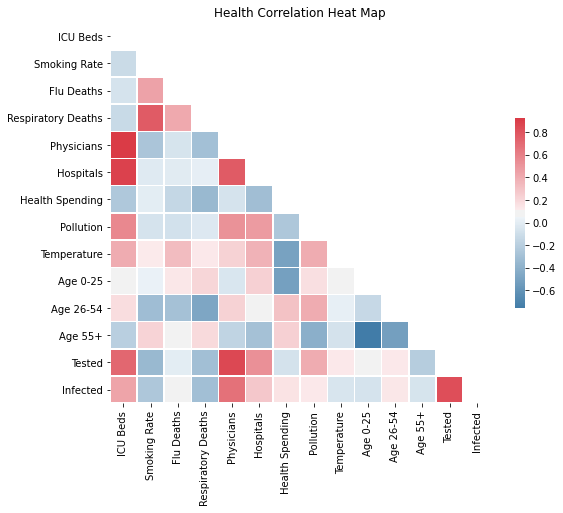

In [ ]:
make_corr_map(covid_health, 'Health Correlation Heat Map')

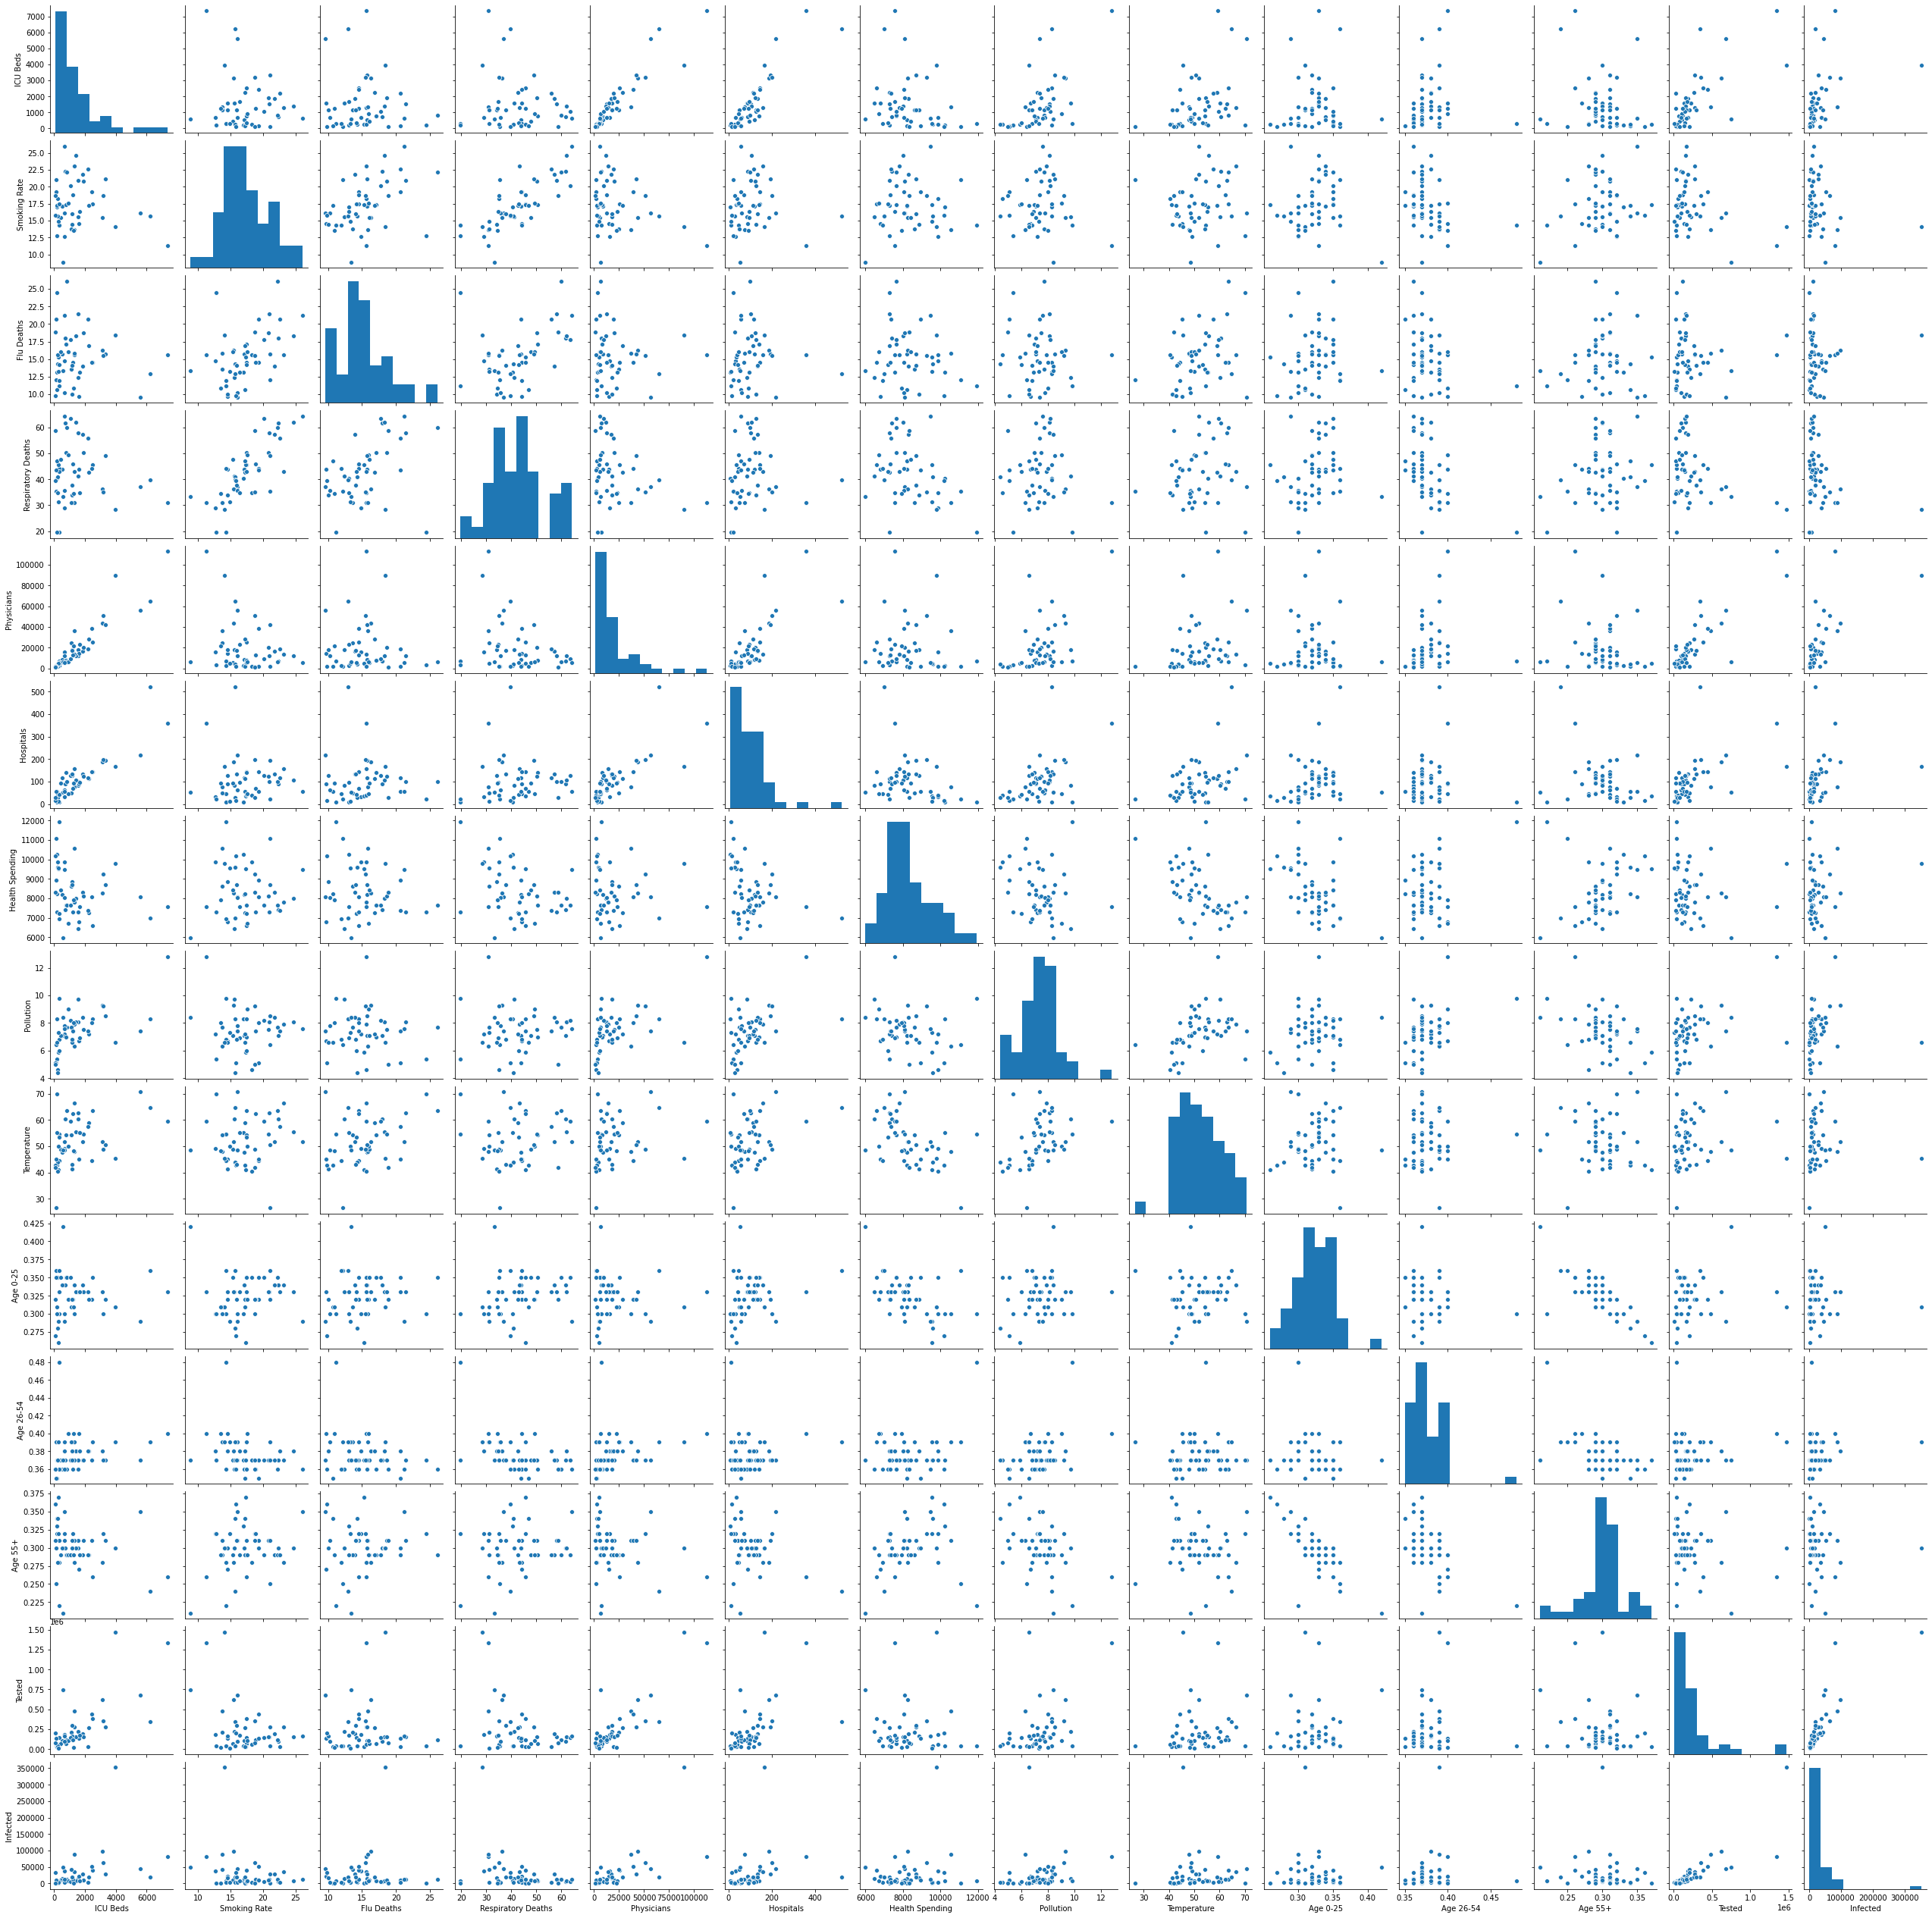

In [ ]:
# Health Factors
sns.pairplot(covid_health)

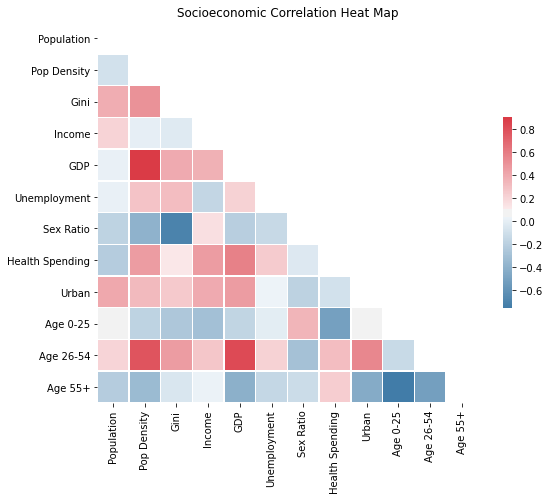

In [ ]:
make_corr_map(covid_socio, 'Socioeconomic Correlation Heat Map')

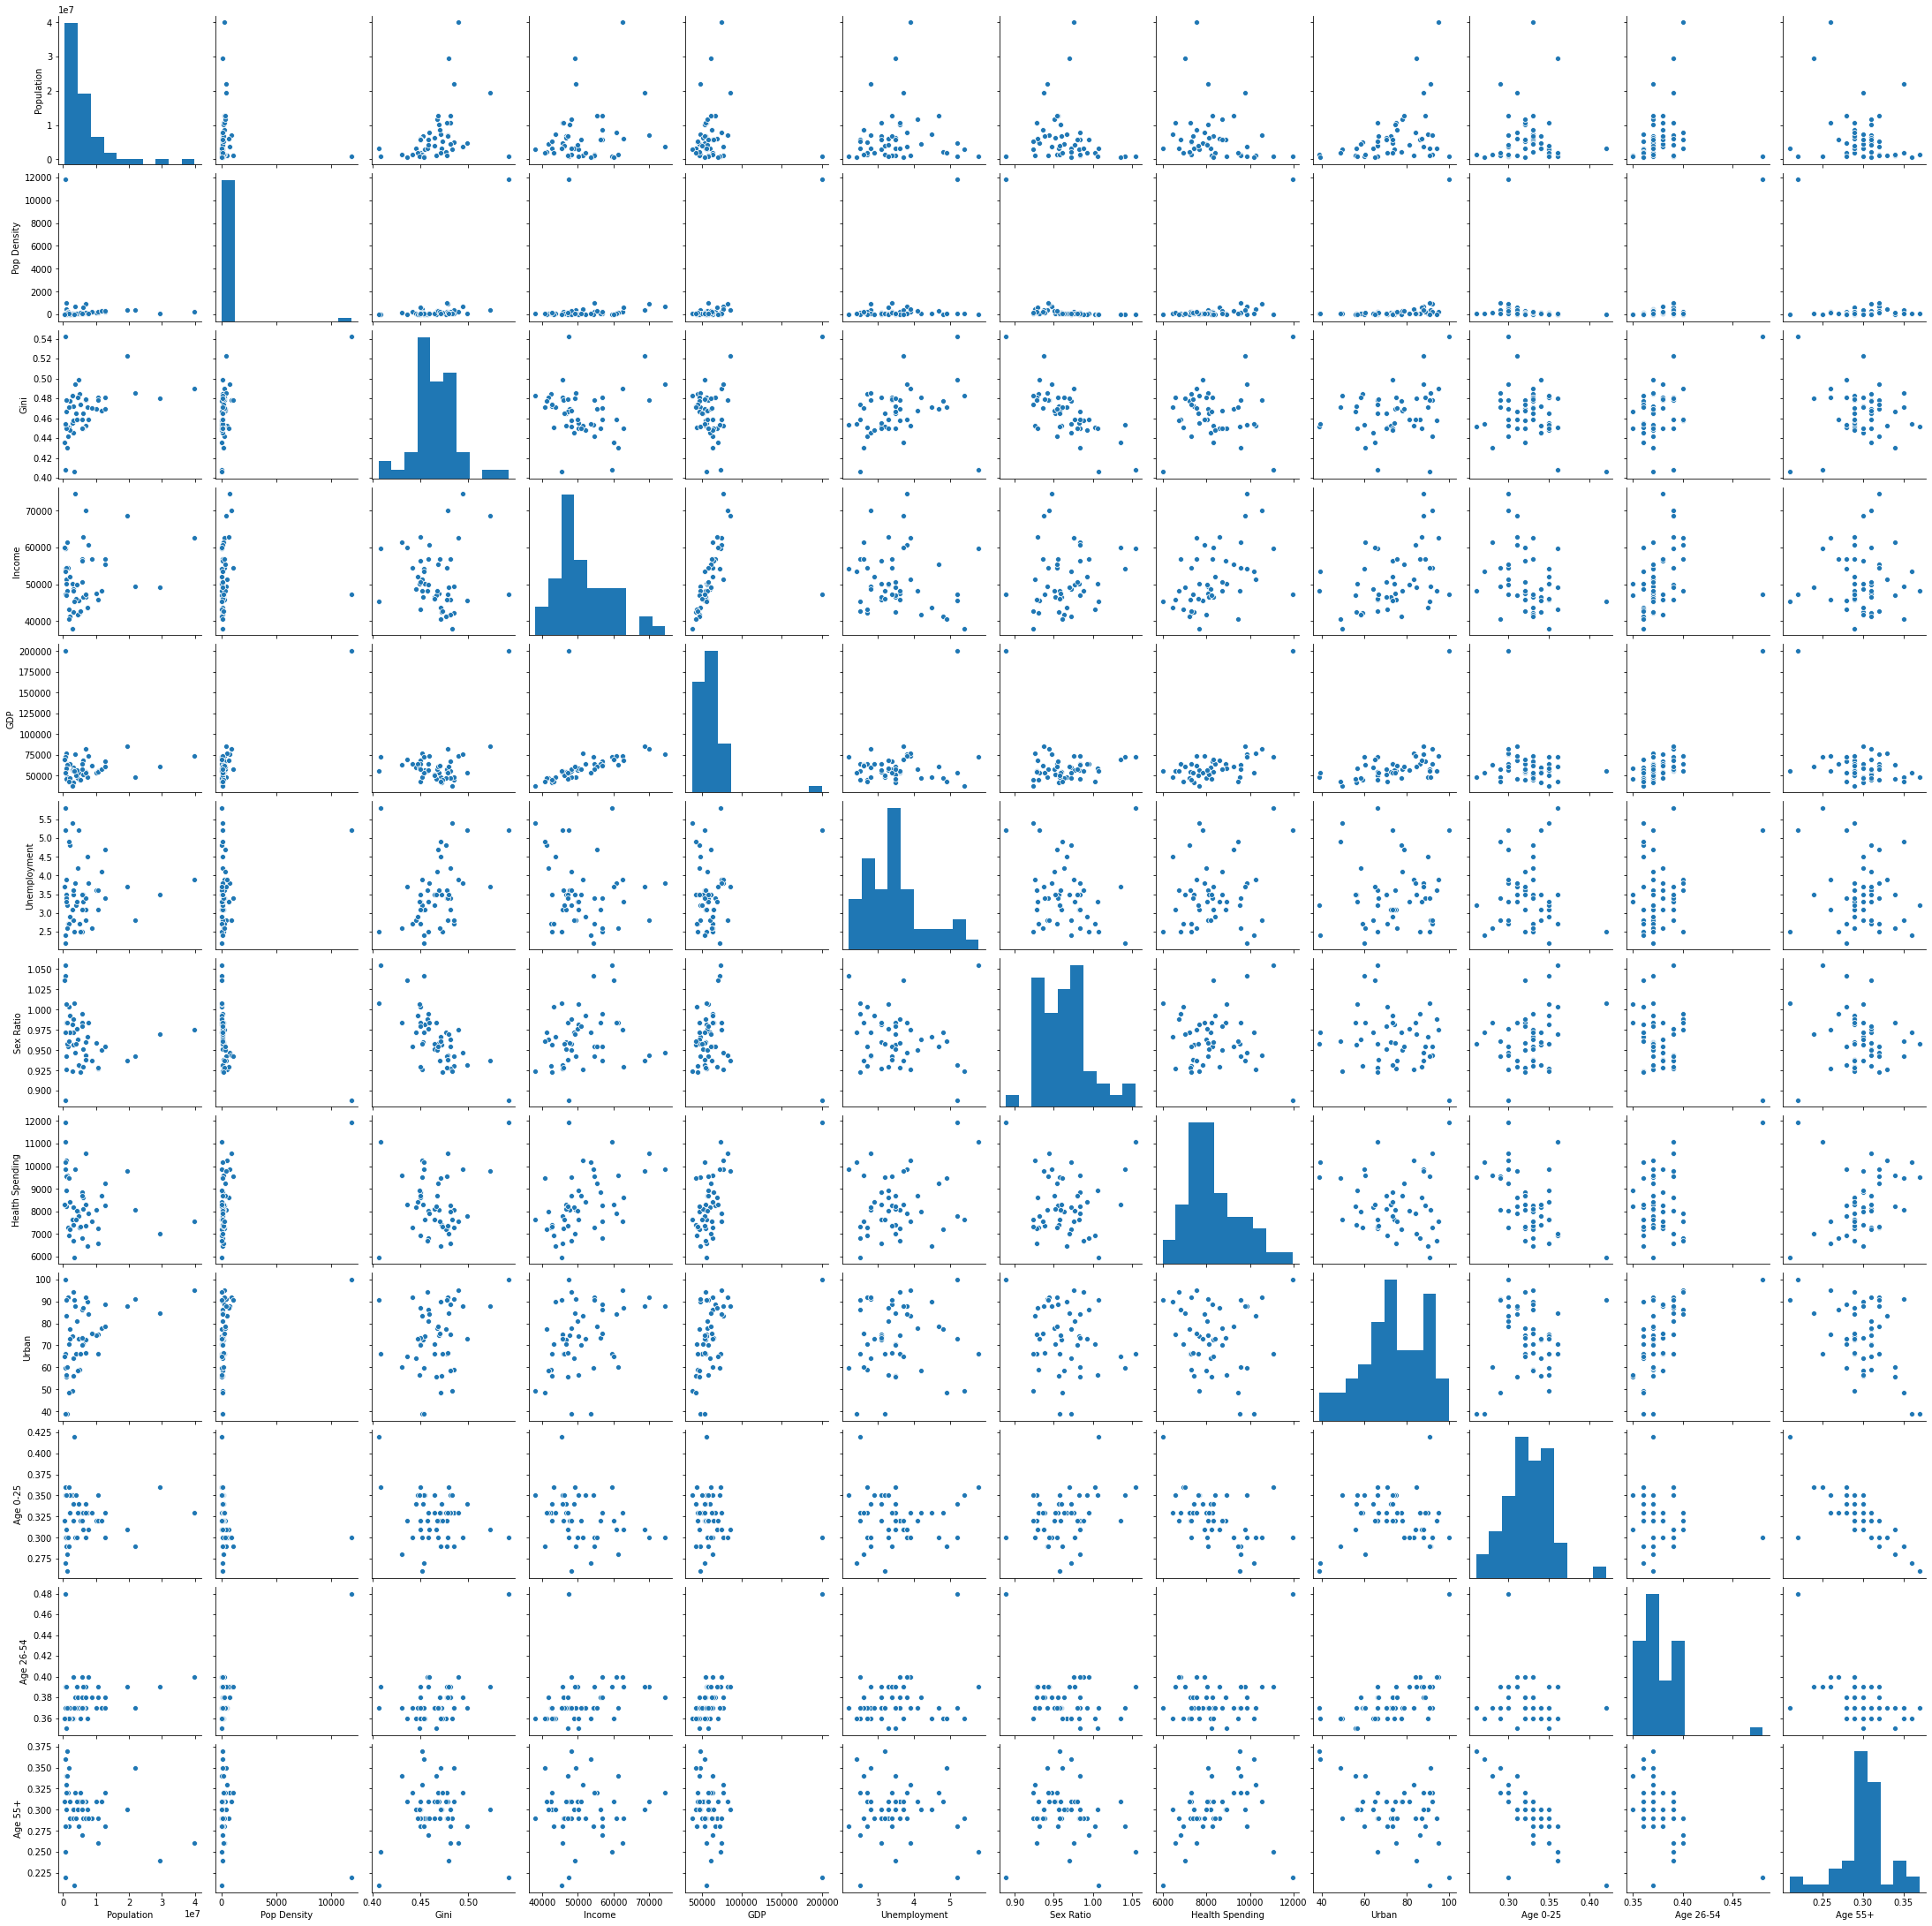

In [ ]:
# Socioeconomic Factors
sns.pairplot(covid_socio)

Several feature correlations are still present after separation by health and socioeconomic factors. Multiple Linear Regression with Feature Selection will be used to predict number of deaths by Health and Socioeconomic Factors. Random Forest and XGBoost Regression will also be used to predict death numbers as well as order features by importance.

## Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_health_sc = sc.fit_transform(X_health)

## **Predicting COVID-19 Deaths based on Health Features**

## *Multiple Linear Regression with Feature Selection*

## Split the Covid Health dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_health, y, test_size = 0.2, random_state = 42)
X_train_sc, X_test_sc, y_train, y_test = train_test_split(X_health_sc, y, test_size = 0.2, random_state = 42)

## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
lreg_health = LinearRegression()

## Feature Selection - LassoCV and RFECV

### Lasso and Cross-Validated Selection Method
- Filter-based feature selection that scores each feature and selects the features with the largest score
- Internally chooses a set of alphas through cross-validation and searches the 'ideal' alpha value by scoring the resulting predictions
- The higher the alpha, the more feature coefficients are zero

In [ ]:
from sklearn.linear_model import LassoCV
reg = LassoCV().fit(X_train, y_train)
importance = np.abs(reg.coef_)

feat_sig = pd.DataFrame(zip(covid_health.columns, importance))
feat_sig.columns = ['Feature', 'Coef']
feat_sig = feat_sig.sort_values('Coef', ascending=False)
feat_sig = feat_sig.reset_index(drop=True)
feat_sig.index += 1 
feat_sig

,Feature,Coef
1,Infected,0.072597
2,Tested,0.002089
3,Physicians,0.001584
4,ICU Beds,0.000000
5,Smoking Rate,0.000000
6,Flu Deaths,0.000000
7,Respiratory Deaths,0.000000
8,Hospitals,0.000000
9,Health Spending,0.000000
10,Pollution,0.000000


The highest coefficients corresponding to Health Feature importance are 'Infected', 'Tested', and 'Physicians'. Let's do Feature Selection using RFECV and compare.

### Recursive Feature Elimination and Cross-Validated Selection Method
- Wrapper-style feature selection algorithm with filter-based internal feature selection
- Fits machine learning algorithm, ranks features by importance, discards the least important ones, refits the model and repeats until...
- Best number of features is selected through cross-validation

### Rank Features

In [ ]:
from sklearn.feature_selection import RFECV
selector = RFECV(lreg_health, step=1, cv=10)
selector = selector.fit(X_train_sc, y_train)

feat_select = pd.DataFrame(zip(covid_health.columns, selector.ranking_, selector.support_))
feat_select.columns = ['Feature', 'Ranking', 'Include?']
feat_select = feat_select.sort_values('Ranking', ascending=True)
feat_select = feat_select.reset_index(drop=True)
feat_select.index += 1 
feat_select

,Feature,Ranking,Include?
1,ICU Beds,1,True
2,Physicians,1,True
3,Tested,1,True
4,Infected,1,True
5,Smoking Rate,2,False
6,Age 55+,3,False
7,Age 26-54,4,False
8,Age 0-25,5,False
9,Respiratory Deaths,6,False
10,Health Spending,7,False


The #1 Features in the ranking are 'ICU Beds', 'Physicians', 'Tested', and 'Infected'. RFECV suggests to keep these four Features, while LassoCV suggests three of the four Features. We will use all four Features from RFECV in our linear regression model. Smoking rate and the age ranges rank a tier lower in the RFECV Feature Selection. With regards to smoking rate, COVID-19 affects the respiratory system, so complications due to smoking can arise. Nonetheless, smoking rate was not included in the model. Somewhat surprisingly, the number of hospitals and average temperature are at the bottom of the rank list and do not influence death numbers.

## Update Features in X_health, X_train, X_test

In [ ]:
X_train_rfe = np.delete(X_train_sc, [1,2,3,5,6,7,8,9,10,11], axis=1)
X_test_rfe = np.delete(X_test_sc, [1,2,3,5,6,7,8,9,10,11], axis=1)

## Fit the Model on the Train set and Predict the Test set Results

In [ ]:
lreg_health.fit(X_train_rfe, y_train)
y_predh_lreg = lreg_health.predict(X_test_rfe)

## Map Predicted Deaths to States

In [ ]:
X_set = sc.inverse_transform(X_test_sc)
state = []
tested = []
tested = list(X_set[:,-2])
for i in range(0, len(covid)):
    if covid.iloc[i,1] in tested:
      state.append(covid.iloc[i,0])

## Table of Predicted vs. Actual COVID-19 Deaths - Test set (in no particular order)

In [ ]:
deaths = pd.DataFrame(zip(state, list(np.around(y_predh_lreg).astype(int)), list(y_test)))
deaths.columns = ['State','Predicted Deaths','Actual Deaths']
deaths = deaths.reset_index(drop=True) 
deaths.index += 1
deaths

,State,Predicted Deaths,Actual Deaths
1,Idaho,86,77
2,Kentucky,658,532
3,Massachusetts,219,182
4,Mississippi,1806,1041
5,Montana,139,366
6,New Hampshire,484,467
7,Nevada,-11,16
8,South Carolina,493,554
9,Vermont,163,373
10,West Virginia,5728,5938


## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(lreg_health.score(X_train_rfe, y_train), 5))

train_score_h = []
train_score_h.append(round(lreg_health.score(X_train_rfe, y_train), 5))

Train score:
0.98224


In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lreg_health, X_train_rfe, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Multiple Linear Regression Model is off by {} deaths per state in the Test set.'.format(round(-scores['test_score'].mean(),0)))

off_target_h = []
off_target_h.append(round(-scores['test_score'].mean(),0))

On average, the Multiple Linear Regression Model is off by 379.0 deaths per state in the Test set.


In [ ]:
from sklearn.metrics import r2_score
print('R^2 for Predicted vs Actual Deaths:')
print(round(r2_score(y_test, y_predh_lreg),5))

r_square_h = []
r_square_h.append(round(r2_score(y_test, y_predh_lreg),5))

R^2 for Predicted vs Actual Deaths:
0.97368


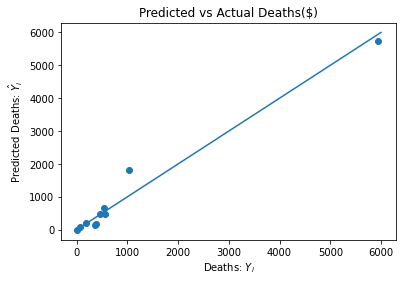

In [ ]:
plt.scatter(y_test, y_predh_lreg)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths($)")

plt.show()

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - Multiple Linear Regression-RFECV')
print('Mean Absolute Error (MAE): {}'.format(round(metrics.mean_absolute_error(y_test, y_predh_lreg), 0)))
print('Root Mean Squared Error (RMSE): {}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_lreg)), 0)))

rmse_health = []
rmse_health.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_lreg)), 0))

COVID-19 Deaths - Multiple Linear Regression-RFECV
Mean Absolute Error (MAE): 169.0
Root Mean Squared Error (RMSE): 273.0


Multiple Linear Regression with Feature Selection is the most accurate, best-fitting model vs. Random Forest and XGBoost Regression models when predicting COVID-19 deaths using Health factors. 

## *Multiple Linear Regression with Feature Extraction*

## Dimensionality Reduction - Principal Component Analysis (PCA)
*   Reduces dimensionality down to uncorrelated variables that maximize variance while minimizing information loss
*   Speeds up machine learning algorithms
*   Unsupervised learning algorithm
*   Ignores the relationship between X and y

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
explained_variance = pca.explained_variance_ratio_

pca_sig = pd.DataFrame(zip(covid_health.columns, explained_variance))
pca_sig.columns = ['Feature', 'Variance Ratio']
pca_sig = pca_sig.sort_values('Variance Ratio', ascending=False)
pca_sig = pca_sig.reset_index(drop=True)
pca_sig.index += 1 
pca_sig

,Feature,Variance Ratio
1,ICU Beds,0.352791
2,Smoking Rate,0.184543
3,Flu Deaths,0.132262
4,Respiratory Deaths,0.101618
5,Physicians,0.073268
6,Hospitals,0.056730
7,Health Spending,0.035462
8,Pollution,0.024893
9,Temperature,0.017666
10,Age 0-25,0.008983


We will select the top 12 features (ICU Beds to Age 55+), which account for pretty much all of the variance in X.

## Update X_train, X_test for PCA

In [ ]:
pca = PCA(n_components = 12)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

## Fit the Model on the Train set and Predict the Test set Results

In [ ]:
lreg_health.fit(X_train_pca, y_train)
y_predh_lreg2 = lreg_health.predict(X_test_pca)

## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(lreg_health.score(X_train_pca, y_train), 5))

train_score_h.append(round(lreg_health.score(X_train_pca, y_train), 5))

Train score:
0.98618


In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lreg_health, X_train_pca, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Multiple Linear Regression Model is off by {} deaths per state in the Test set.'.format(round(-scores['test_score'].mean(),0)))

off_target_h.append(round(-scores['test_score'].mean(),0))

On average, the Multiple Linear Regression Model is off by 453.0 deaths per state in the Test set.


In [ ]:
from sklearn.metrics import r2_score
print('R^2 for Predicted vs Actual Deaths:')
print(round(r2_score(y_test, y_predh_lreg2),5))

r_square_h.append(round(r2_score(y_test, y_predh_lreg2),5))

R^2 for Predicted vs Actual Deaths:
0.90152


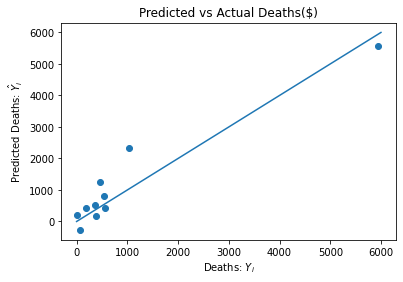

In [ ]:
plt.scatter(y_test, y_predh_lreg2)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths($)")

plt.show()

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - Multiple Linear Regression-PCA')
print('Mean Absolute Error (MAE): {}'.format(round(metrics.mean_absolute_error(y_test, y_predh_lreg2), 0)))
print('Root Mean Squared Error (RMSE): {}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_lreg2)), 0)))

rmse_health.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_lreg2)), 0))

COVID-19 Deaths - Multiple Linear Regression-PCA
Mean Absolute Error (MAE): 402.0
Root Mean Squared Error (RMSE): 528.0


The R^2 for Predicted vs Actual Deaths (0.90139) is slightly worse after PCA vs. after Feature Selection, with a Train Score (y_train vs x_train) of 0.98618. PCA is an unsupervised learning estimator, focuses solely on Features (X), and whittles them down via linear combination to the features that represent maximum variance. It **does not** take into account the dependent variable (y) or the model itself. We show the Linear Regression model with PCA here to compare it to the model with LassoCV/RFECV, which is our model of choice.

## *Random Forest Regression*
- Bagging/Bootstrapping technique - Random sampling of subset of data reduces bias and variance
- Ensemble method has multiple decision tree models run independently, then output is averaged/aggregated

## Split the Health dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_health, y, test_size = 0.2, random_state = 42)

## Train the Random Forest Regression model on the Training set

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_health = RandomForestRegressor(random_state = 42)
rf_health.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(rf_health, X_train, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Random Forest Regression Model is off by {:,} deaths per state.'.format(round(-scores['test_score'].mean(),0)))

off_target_h.append(round(-scores['test_score'].mean(),0))

On average, the Random Forest Regression Model is off by 1,154.0 deaths per state.


Average off-target deaths is significantly higher with Random Forest compared to with multiple linear regression.

## Predict the Test set Results

In [ ]:
y_predh_rf = rf_health.predict(X_test)

## Map Predicted Deaths to States in Test set

In [ ]:
state = []
tested = []
tested = list(X_test[:,-2])
for i in range(0, len(covid)):
    if covid.iloc[i,1] in tested:
      state.append(covid.iloc[i,0])

## Table of Predicted vs. Actual COVID-19 Deaths - Test set (in no particular order)

In [ ]:
deaths = pd.DataFrame(zip(state, list(y_predh_rf), list(y_test)))
deaths.columns = ['State','Predicted Deaths','Actual Deaths']
deaths = deaths.reset_index(drop=True) 
deaths.index += 1
deaths

,State,Predicted Deaths,Actual Deaths
1,Idaho,83.05,77
2,Kentucky,478.29,532
3,Massachusetts,83.47,182
4,Mississippi,2365.60,1041
5,Montana,357.16,366
6,New Hampshire,591.09,467
7,Nevada,74.68,16
8,South Carolina,417.10,554
9,Vermont,309.92,373
10,West Virginia,4105.84,5938


## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(rf_health.score(X_train, y_train), 5))

train_score_h.append(round(rf_health.score(X_train, y_train), 5))

Train score:
0.8938


In [ ]:
from sklearn.metrics import r2_score
print('R^2:')
print(round(r2_score(y_test, y_predh_rf), 5))

r_square_h.append(round(r2_score(y_test, y_predh_rf),5))

R^2:
0.8178


Random Forest R^2 is the worst of the three models used to predict COVID-19 deaths using Health factors

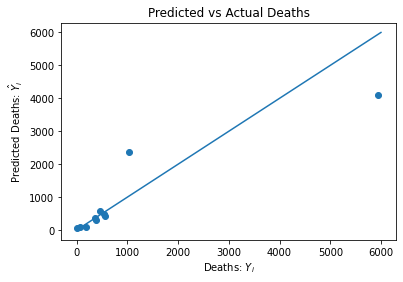

In [ ]:
plt.scatter(y_test, y_predh_rf)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths")

plt.show()

## Feature Performance

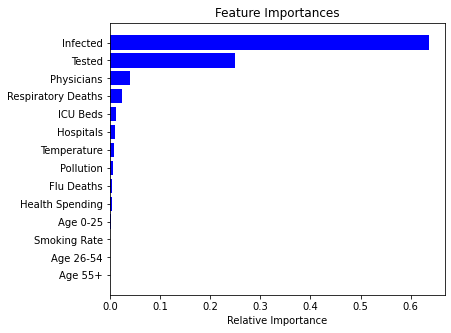

In [ ]:
rfhealth_importances = rf_health.feature_importances_
indices = np.argsort(rfhealth_importances)

plt.figure(figsize=(6,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), rfhealth_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), covid_health.columns[indices])
plt.xlabel('Relative Importance')

plt.show()

The top two features are the numbers of (1) Infected and (2) Tested and are the drivers behind predicting the death numbers in the Health Random Forest model. This observation makes sense because COVID-19 infections can lead to increased death.

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - Random Forest')
print('Mean Absolute Error (MAE): {}'.format(round(metrics.mean_absolute_error(y_test, y_predh_rf), 0)))
print('Root Mean Squared Error (RMSE): {}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_rf)), 0)))

rmse_health.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_rf)), 0))

COVID-19 Deaths - Random Forest
Mean Absolute Error (MAE): 371.0
Root Mean Squared Error (RMSE): 719.0


## *XGBoost Regression*
- Builds sequential trees using parallel implementation by switching order of loops (1) to enumerate leaf nodes and (2) to calculate features
- Tree pruning - 'max-depth' parameter defined first then trees 'pruned' to improve computational performance
- Finds optimal split points in weighted datasets
- Built-in regularization via LASSO (L1) or Ridge (L2) to prevent overfitting
- Built-in cross validation

## Train the XGBoost Regression model on the Training set

In [ ]:
# Try the XGBoost model to fit the Health data
from xgboost import XGBRegressor
xgb_health = XGBRegressor(n_estimators=1000, max_depth=3, gamma=1, silent=True)
xgb_health.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(xgb_health, X_train, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the XGBoost Regression Model is off by {:,} deaths per state.'.format(round(-scores['test_score'].mean(),0)))

off_target_h.append(round(-scores['test_score'].mean(),0))

On average, the XGBoost Regression Model is off by 1,317.0 deaths per state.


Average off-target deaths is significantly higher with XGBoost compared to with multiple linear regression and is in line with the off-target result for Random Forest.

## Predict the Test set Results

In [ ]:
y_predh_xgb = xgb_health.predict(X_test)

## Table of Predicted vs. Actual COVID-19 Deaths - Test set (in no particular order)

In [ ]:
deaths = pd.DataFrame(zip(state, list(y_predh_xgb), list(y_test)))
deaths.columns = ['State','Predicted Deaths','Actual Deaths']
deaths = deaths.reset_index(drop=True) 
deaths.index += 1
deaths

,State,Predicted Deaths,Actual Deaths
1,Idaho,6.386649,77
2,Kentucky,445.438690,532
3,Massachusetts,125.172325,182
4,Mississippi,2394.958252,1041
5,Montana,338.205994,366
6,New Hampshire,624.894531,467
7,Nevada,48.472454,16
8,South Carolina,392.363098,554
9,Vermont,140.146225,373
10,West Virginia,4962.542480,5938


## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(xgb_health.score(X_train, y_train), 5))

train_score_h.append(round(xgb_health.score(X_train, y_train), 5))

Train score:
1.0


In [ ]:
from sklearn.metrics import r2_score
print('R^2:')
print(round(r2_score(y_test, y_predh_xgb), 5))

r_square_h.append(round(r2_score(y_test, y_predh_xgb),5))

R^2:
0.89745


XGBoost R^2 result drops off compared to multiple linear regression R^2.

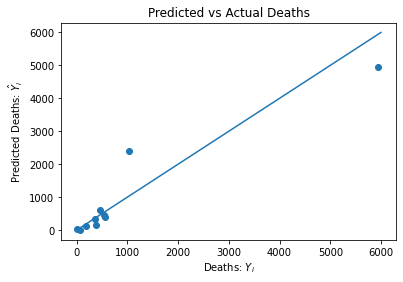

In [ ]:
plt.scatter(y_test, y_predh_xgb)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths")

plt.show()

## Feature Performance

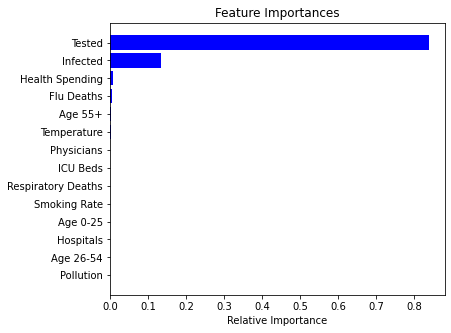

In [ ]:
xgbhealth_importances = xgb_health.feature_importances_
indices = np.argsort(xgbhealth_importances)

plt.figure(figsize=(6,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), xgbhealth_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), covid_health.columns[indices])
plt.xlabel('Relative Importance')

plt.show()

The top two features are the numbers of (1) Tested and (2) Infected and are the drivers behind predicting the death numbers in the Health XGBoost model. The reported number of COVID-19 deaths are known from tracking the patient initially testing positive.

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - XGBoost')
print('Mean Absolute Error (MAE): {}'.format(round(metrics.mean_absolute_error(y_test, y_predh_xgb), 0)))
print('Root Mean Squared Error (RMSE): {}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_xgb)), 0)))

rmse_health.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_predh_xgb)), 0))

COVID-19 Deaths - XGBoost
Mean Absolute Error (MAE): 316.0
Root Mean Squared Error (RMSE): 539.0


## **Predicting COVID-19 Deaths based on Socioeconomic Features**

## Encode categorical data

In [ ]:
# OneHotEncode US States and US Closure Date for Multiple Linear Regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# For Linear Regression
ct_ohe = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0,1])], remainder='passthrough')
X_socio_ohe = np.array(ct_ohe.fit_transform(X_socio))

# For Mutual Info Classification
ct_oe = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(), [0,1])], remainder='passthrough')
X_socio_oe = np.array(ct_oe.fit_transform(X_socio))

# For Tree Models
ct_oetr = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(), [0])], remainder='passthrough')
X_socio_oetr = np.array(ct_oetr.fit_transform(X_socio_tr))

## Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_socioohe_sc = sc.fit_transform(X_socio_ohe)
X_sociooe_sc = sc.fit_transform(X_socio_oe)

## Split the Socioeconomic dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
# Linear Regression
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_socioohe_sc, y, test_size = 0.2, random_state = 42)

# Mutual Info Classification
X_train_oe, X_test_oe, y_train, y_test = train_test_split(X_sociooe_sc, y, test_size = 0.2, random_state = 42)

# Tree Models
X_train_oetr, X_test_oetr, y_train, y_test = train_test_split(X_socio_oetr, y, test_size = 0.2, random_state = 42)

## *Multiple Linear Regression*

## Feature Selection - LassoCV

In [ ]:
from sklearn.linear_model import LassoCV
reg = LassoCV().fit(X_train_ohe, y_train)
importance = np.abs(reg.coef_)

# Sum Coef's for States (Categorical)
feat_states = np.array(sum(importance[0:50]))
# Sum Coef's for Dates (Categorical)
feat_dates = np.array(sum(importance[50:56]))

feat_rest = np.array(importance[56:])
# Gather coef values for states, dates, and rest of features
feat_socio = np.append(feat_states, feat_dates)
feat_socio = np.append(feat_socio, feat_rest)

feat_sig = pd.DataFrame(zip(covid_socio.columns, feat_socio))
feat_sig.columns = ['Feature', 'Coef']
feat_sig = feat_sig.sort_values('Coef', ascending=False)
feat_sig = feat_sig.reset_index(drop=True)
feat_sig.index += 1 
feat_sig

,Feature,Coef
1,State,6532.872808
2,Population,576.792211
3,Urban,57.741938
4,School Closure Date,48.060651
5,Sex Ratio,25.255845
6,Pop Density,0.000000
7,Gini,0.000000
8,Income,0.000000
9,GDP,0.000000
10,Unemployment,0.000000


The highest coefficients corresponding to Socioeconomic Feature importance are 'State', 'Population', 'Urban', 'School Closure Date', and 'Sex Ratio'. We will use these Features in the Linear Regression model.

## Update Features in X_train, X_test

In [ ]:
X_train_lreg = np.delete(X_train_ohe, [57,58,59,60,61,63,65,66,67], axis=1)
X_test_lreg = np.delete(X_test_ohe, [57,58,59,60,61,63,65,66,67], axis=1)

## Train the Multiple Linear Regression model on the Training set

In [ ]:
from sklearn.linear_model import LinearRegression
lreg_socio = LinearRegression()
lreg_socio.fit(X_train_lreg, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lreg_socio, X_train_lreg, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Linear Regression Model is off by {:,} deaths per state in the Test set.'.format(round(-scores['test_score'].mean(),0)))

On average, the Linear Regression Model is off by 1,753.0 deaths per state in the Test set.


## Predict the Test set Results

In [ ]:
y_pred_socio = lreg_socio.predict(X_test_lreg)

## Evaluate the Performance

In [ ]:
print("Train score:")
print(lreg_socio.score(X_train_lreg, y_train))

Train score:
1.0


In [ ]:
from sklearn.metrics import r2_score
print('R^2 for Predicted vs Actual Deaths:')
print(round(r2_score(y_test, y_pred_socio),5))

R^2 for Predicted vs Actual Deaths:
0.37146


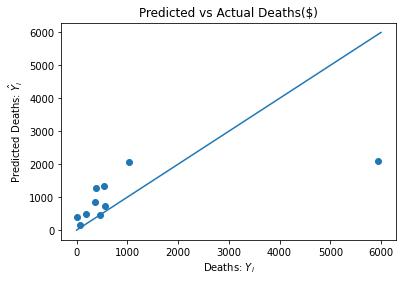

In [ ]:
plt.scatter(y_test, y_pred_socio)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths($)")

plt.show()

### The Training Score is perfect (1.0), yet R^2 is very poor. These are hallmarks of overfitting. Let's select Features using another method.

## Feature Selection - Mutual Information
* Evaluates the gain of each X variable in the context of the target (y) variable
* Calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable

Feature Scores
Feature 0: 0.000000
Feature 1: 0.000000
Feature 2: 0.094800
Feature 3: 0.142650
Feature 4: 0.052716
Feature 5: 0.000000
Feature 6: 0.149648
Feature 7: 0.000000
Feature 8: 0.078238
Feature 9: 0.000000
Feature 10: 0.000000
Feature 11: 0.052968
Feature 12: 0.000000
Feature 13: 0.000000


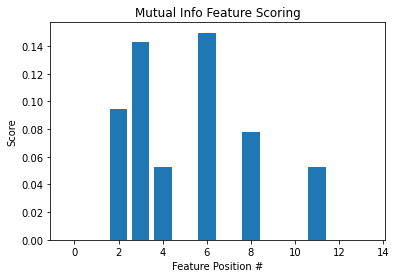

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train_oe, y_train)
X_train_fs = fs.transform(X_train_oe)
X_test_fs = fs.transform(X_test_oe)

# Feature Scores
print("Feature Scores")
for i in range(len(fs.scores_)):
  print('Feature %d: %f' % (i, fs.scores_[i]))
 
# Plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

plt.xlabel("Feature Position #")
plt.ylabel("Score")
plt.title("Mutual Info Feature Scoring")

plt.show()

Select Features 2, 3, 4, 6, 8, 11 to run the Linear Regression model.
These features are 2: Pop Density; 3: Gini; 4: Income; 6: Unemployment; 8: Health Spending; 11: Age 26-54

## Update Features in X_train, X_test

In [ ]:
X_train_lreg = np.delete(X_train_oe, [0,1,5,7,9,10,12,13], axis=1)
X_test_lreg = np.delete(X_test_oe, [0,1,5,7,9,10,12,13], axis=1)

## Train the Multiple Linear Regression model on the Training set

In [ ]:
from sklearn.linear_model import LinearRegression
lreg_socio = LinearRegression()
lreg_socio.fit(X_train_lreg, y_train)

from sklearn.model_selection import cross_validate
scores = cross_validate(lreg_socio, X_train_lreg, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Linear Regression Model is off by {:,} deaths per state in the Test set.'.format(round(-scores['test_score'].mean(),0)))

off_target_se = []
off_target_se.append(round(-scores['test_score'].mean(),0))

On average, the Linear Regression Model is off by 2,478.0 deaths per state in the Test set.


## Predict the Test set Results

In [ ]:
y_preds_lreg = lreg_socio.predict(X_test_lreg)

## Map Predicted Deaths to State

In [ ]:
X_set = sc.inverse_transform(X_test_oe)
state = []
sex_ratio = []
sex_ratio = list(X_set[:,8])
for i in range(0, len(covid)):
    if covid.iloc[i,11] in sex_ratio:
      state.append(covid.iloc[i,0])

## Table of Predicted vs. Actual COVID-19 Deaths - Test set (in no particular order)

In [ ]:
deaths = pd.DataFrame(zip(state, list(np.around(y_preds_lreg).astype(int)), list(y_test)))
deaths.columns = ['State','Predicted Deaths','Actual Deaths']
deaths = deaths.reset_index(drop=True) 
deaths.index += 1
deaths

,State,Predicted Deaths,Actual Deaths
1,Idaho,-2630,77
2,Kentucky,193,532
3,Massachusetts,-1387,182
4,Mississippi,-778,1041
5,Montana,883,366
6,New Hampshire,-956,467
7,Nevada,-632,16
8,South Carolina,158,554
9,Vermont,210,373
10,West Virginia,5179,5938


# Evaluate the Performance

In [ ]:
print("Train score:")
print(lreg_socio.score(X_train_lreg, y_train))

train_score_se = []
train_score_se.append(round(lreg_socio.score(X_train_lreg, y_train), 5))

Train score:
0.483724913426099


In [ ]:
from sklearn.metrics import r2_score
print('R^2 for Predicted vs Actual Deaths:')
print(round(r2_score(y_test, y_preds_lreg),5))

r_square_se = []
r_square_se.append(round(r2_score(y_test, y_preds_lreg),5))

R^2 for Predicted vs Actual Deaths:
0.41141


R^2 and Train score are now in the same vicinity but very poor results.

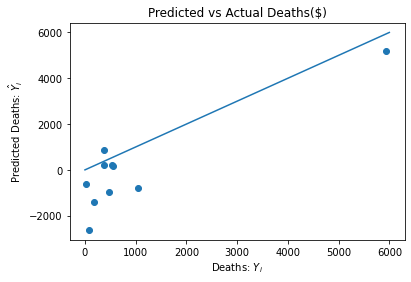

In [ ]:
plt.scatter(y_test, y_preds_lreg)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths($)")

plt.show()

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - Multiple Linear Regression-Mutual Information')
print('Mean Absolute Error (MAE): {:,}'.format(round(metrics.mean_absolute_error(y_test, y_preds_lreg), 0)))
print('Root Mean Squared Error (RMSE): {:,}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_preds_lreg)), 0)))

rmse_socio = []
rmse_socio.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_preds_lreg)), 0))

COVID-19 Deaths - Multiple Linear Regression-Mutual Information
Mean Absolute Error (MAE): 1,034.0
Root Mean Squared Error (RMSE): 1,292.0


### The multiple linear regression model gives very poor performance!

## *Random Forest Regression*

## Train the Random Forest Regression model on the Training set

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_socio = RandomForestRegressor(n_estimators=1000, random_state = 42)
rf_socio.fit(X_train_oetr, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(rf_socio, X_train_oetr, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Linear Regression Model is off by {:,} deaths per state in the Test set.'.format(round(-scores['test_score'].mean(),0)))

off_target_se.append(round(-scores['test_score'].mean(),0))

On average, the Linear Regression Model is off by 1,892.0 deaths per state in the Test set.


## Predict the Test set Results

In [ ]:
y_preds_rf = rf_socio.predict(X_test_oetr)

## Map Predicted Deaths to States in Test

In [ ]:
state = []
sex_ratio = []
sex_ratio = list(X_test_oetr[:,-6])
for i in range(0, len(covid)):
    if covid.iloc[i,11] in sex_ratio:
      state.append(covid.iloc[i,0])

## Table of Predicted vs. Actual COVID-19 Deaths - Test set (in no particular order)

In [ ]:
deaths = pd.DataFrame(zip(state, list(y_preds_rf), list(y_test)))
deaths.columns = ['State','Predicted Deaths','Actual Deaths']
deaths = deaths.reset_index(drop=True) 
deaths.index += 1
deaths

,State,Predicted Deaths,Actual Deaths
1,Idaho,526.759,77
2,Kentucky,935.585,532
3,Massachusetts,349.428,182
4,Mississippi,314.381,1041
5,Montana,835.166,366
6,New Hampshire,372.418,467
7,Nevada,287.862,16
8,South Carolina,654.608,554
9,Vermont,535.317,373
10,West Virginia,9984.556,5938


## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(rf_socio.score(X_train_oetr, y_train), 5))

train_score_se.append(round(rf_socio.score(X_train_oetr, y_train), 5))

Train score:
0.81121


In [ ]:
from sklearn.metrics import r2_score
print('R^2:')
print(round(r2_score(y_test, y_preds_rf), 5))

r_square_se.append(round(r2_score(y_test, y_preds_rf),5))

R^2:
0.37798


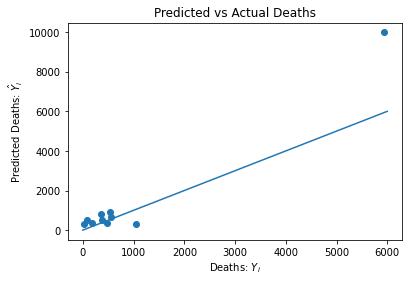

In [ ]:
plt.scatter(y_test, y_preds_rf)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths")

plt.show()

## Feature Performance

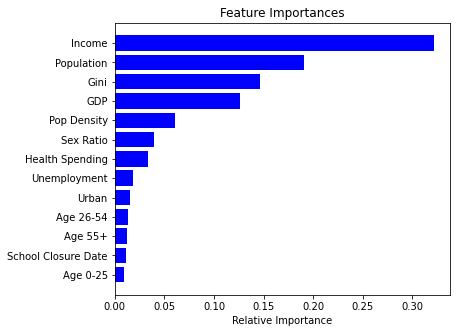

In [ ]:
rfsocio_importances = rf_socio.feature_importances_
indices = np.argsort(rfsocio_importances)

plt.figure(figsize=(6,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), rfsocio_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), covid_socio_tr.columns[indices])
plt.xlabel('Relative Importance')

plt.show()

The top features are (1) Income; (2) Population; (3) Gini; and (4) GDP for the Socioeconomic Random Forest model.

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - Random Forest')
print('Mean Absolute Error (MAE): {}'.format(round(metrics.mean_absolute_error(y_test, y_preds_rf), 0)))
print('Root Mean Squared Error (RMSE): {:,}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_preds_rf)), 0)))

rmse_socio.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_preds_rf)), 0))

COVID-19 Deaths - Random Forest
Mean Absolute Error (MAE): 689.0
Root Mean Squared Error (RMSE): 1,328.0


## *XGBoost Regression*

## Train the XGBoost Regression model on the Training set

In [ ]:
# Try the XGBoost model to fit the Socioeconomic data
from xgboost import XGBRegressor
xgb_socio = XGBRegressor(n_estimators=1000, max_depth=2, silent=True)
xgb_socio.fit(X_train_oetr, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(xgb_socio, X_train_oetr, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the Linear Regression Model is off by {:,} deaths per state in the Test set.'.format(round(-scores['test_score'].mean(),0)))

off_target_se.append(round(-scores['test_score'].mean(),0))

On average, the Linear Regression Model is off by 2,308.0 deaths per state in the Test set.


## Predict the Test set Results

In [ ]:
y_preds_xgb = xgb_socio.predict(X_test_oetr)

## Table of Predicted vs. Actual COVID-19 Deaths - Test set (in no particular order)

In [ ]:
deaths = pd.DataFrame(zip(state, list(y_preds_xgb), list(y_test)))
deaths.columns = ['State','Predicted Deaths','Actual Deaths']
deaths = deaths.reset_index(drop=True) 
deaths.index += 1
deaths

,State,Predicted Deaths,Actual Deaths
1,Idaho,486.864868,77
2,Kentucky,700.662598,532
3,Massachusetts,261.939819,182
4,Mississippi,324.357330,1041
5,Montana,826.543396,366
6,New Hampshire,621.094666,467
7,Nevada,277.929291,16
8,South Carolina,358.885620,554
9,Vermont,297.980804,373
10,West Virginia,3395.009766,5938


## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(xgb_socio.score(X_train_oetr, y_train), 5))

train_score_se.append(round(xgb_socio.score(X_train_oetr, y_train), 5))

Train score:
1.0


In [ ]:
from sklearn.metrics import r2_score
print('R^2:')
print(round(r2_score(y_test, y_preds_xgb), 5))

r_square_se.append(round(r2_score(y_test, y_preds_xgb),5))

R^2:
0.73436


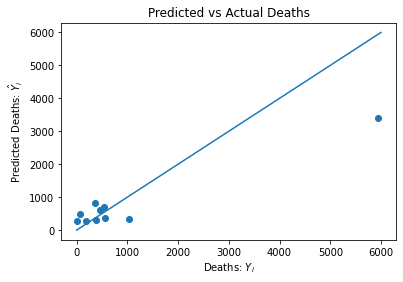

In [ ]:
plt.scatter(y_test, y_preds_xgb)
plt.plot(range(6000), range(6000))

plt.xlabel("Deaths: $Y_i$")
plt.ylabel("Predicted Deaths: $\hat{Y}_i$")
plt.title("Predicted vs Actual Deaths")

plt.show()

## Feature Performance

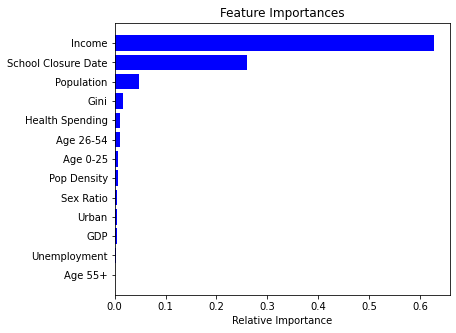

In [ ]:
xgbsocio_importances = xgb_socio.feature_importances_
indices = np.argsort(xgbsocio_importances)

plt.figure(figsize=(6,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), xgbsocio_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), covid_socio_tr.columns[indices])
plt.xlabel('Relative Importance')

plt.show()

Income and School Closure Date the driving features behind predicting the death numbers in the Socioeconomic XGBoost model.

In [ ]:
from sklearn import metrics
print('COVID-19 Deaths - XGBoost')
print('Mean Absolute Error (MAE): {}'.format(round(metrics.mean_absolute_error(y_test, y_preds_xgb), 0)))
print('Root Mean Squared Error (RMSE): {}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_preds_xgb)), 0)))

rmse_socio.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_preds_xgb)), 0))

COVID-19 Deaths - XGBoost
Mean Absolute Error (MAE): 506.0
Root Mean Squared Error (RMSE): 868.0


## Model Summary

In [ ]:
model = ['Linear Regression-RFECV', 'Linear Regression-PCA', 'Random Forest', 'XGBoost']
sum_stats = pd.DataFrame(zip(model, train_score_h, r_square_h, off_target_h, rmse_health))
sum_stats.columns = ['COVID-Health Death Model', 'Train Score', 'Pred vs Actual R^2', 'Avg Off-Target Deaths', "RMSE"]
sum_stats = sum_stats.sort_values('Pred vs Actual R^2', ascending=False)
sum_stats = sum_stats.reset_index(drop=True)
sum_stats.index += 1 
sum_stats

,COVID-Health Death Model,Train Score,Pred vs Actual R^2,Avg Off-Target Deaths,RMSE
1,Linear Regression-RFECV,0.98224,0.97368,379.0,273.0
2,Linear Regression-PCA,0.98618,0.90152,453.0,528.0
3,XGBoost,1.00000,0.89745,1317.0,539.0
4,Random Forest,0.89380,0.81780,1154.0,719.0


In [ ]:
model = ['Linear Regression-Mutual Info FS', 'Random Forest', 'XGBoost']
sum_stats = pd.DataFrame(zip(model, train_score_se, r_square_se, off_target_se, rmse_socio))
sum_stats.columns = ['COVID-Socioeconomic Death Model', 'Train Score', 'Pred vs Actual R^2', 'Avg Off-Target Deaths', 'RMSE']
sum_stats = sum_stats.sort_values('Pred vs Actual R^2', ascending=False)
sum_stats = sum_stats.reset_index(drop=True)
sum_stats.index += 1 
sum_stats

,COVID-Socioeconomic Death Model,Train Score,Pred vs Actual R^2,Avg Off-Target Deaths,RMSE
1,XGBoost,1.00000,0.73436,2308.0,868.0
2,Linear Regression-Mutual Info FS,0.48372,0.41141,2478.0,1292.0
3,Random Forest,0.81121,0.37798,1892.0,1328.0


## Discussion

#### COVID-19 Health Models
Multiple Linear Regression with RFECV feature selection is the best model to predict COVID-19 death numbers. The high R^2 value combined with low off-target death numbers gives this model an edge over XGBoost and Random Forest. In general, the data only reflect reported cases, and it is anticipated that the number of COVID-19 cases that go undetected or are suspected post mortem is significant. We do not have a true prediction of COVID-19 deaths since results are often delayed by 7-14 days and since the testing capacity is nowhere near where it should be. Consequently, these issues can create a ceiling effect on the prediction of death numbers, making it difficult to assess the true contributions of all health features other than the dominant but underreported Tested and Infected numbers.

#### COVID-19 Socioeconomic Models
XGBoost is the best model to predict COVID-19 death numbers since this model gives the highest R^2 value. Note that these off-target numbers are higher than those in the health models due to small sample size. The Linear Regression model had overfitting issues with the Training dataset, so we did Feature Selection with Mutual Information.

## Conclusion

#### **Overall, the Multiple Linear Regression-RFECV model with Health data is the most accurate for predicting COVID-19 death numbers. The number of infections and testings from Health features are critical features in linear regression and tree models. In comparison, socioeconomic factors cannot predict the number of deaths as accurately as health factors. In general, we need to stick to simple models, such as linear regression, and stay away from Tree models to get accurate predictions of COVID-19 death numbers since the number of observations (n) is relatively small. There are only 51 samples representing 50 states + the District of Columbia.**